<h2>Requirements</h2>

In [3]:
#!pip install opencv-python

In [14]:
#pip install tensorflow

  Stored in directory: C:\Users\Shashi\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built termcolor
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0
Note: you may need to restart the kernel to use updated packages.


In [16]:
#!pip install -q efficientnet

In [17]:
#pip install keras

Note: you may need to restart the kernel to use updated packages.


In [18]:
#pip install plotly

  Stored in directory: C:\Users\Shashi\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


<h2>Data Description</h2>

The data which is used in this research is taken from the <b style="font-size: 20px"><a href="https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data">plant-pathology-2020-fgvc7</a></b>

<h3>1. Images</h3>
<p>A folder containing the train and test images, in jpg format.</p>

<h3>2. Train Data</h3><p>(train.csv)</p>

<p>Data which is used to train the models is stored in this file</p>

<h5>Columns:</h5>

<p><b>image_id:</b> ID of the image which is located in images folder</p>
<p><b>healthy</b> This column describes if the leaf is healthy or unhealthy if healthy it is marked as 1 else it is 0</p>
<p><b>scab</b> This column describes if the leaf is diseased with Scab or not if the leaf is effected with Scab it is marked as 1 else it is 0</p>
<p><b>rust</b> This column describes if the leaf is diseased with Rust or not if the leaf is effected with Rust it is marked as 1 else it is 0</p>
<p><b>multiple_diseases</b> This column describes if the leaf is diseased with multiple diseases (like scab and rust) or not if the leaf is effected with multiple diseases it is marked as 1 else it is 0</p>

<h3>3. Test Data</h3>

<p>This data is used to test the model how effectively the model is working on unseen data</p>

<h5>Columns:</h5>
<p><b>image_id:</b> ID of the image which is located in images folder</p>

In [1]:
import gc
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2

from tqdm import tqdm
# tqdm.pandas()

import tensorflow as tf

import efficientnet.tfkeras as efn

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.3.1
2.4.0


<h2>Load the Data</h2>

In [3]:
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'
images_path = 'data/images/'

In [4]:
train = pd.read_csv(train_data_path)

In [5]:
test = pd.read_csv(test_data_path)

<h2>Exploring the Data</h2>

In [6]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [7]:
# Rows and Columns in the data

train.shape

(1821, 5)

In [8]:
# summary of the dataset: 1821 rows, 5 columns, no null values

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
image_id             1821 non-null object
healthy              1821 non-null int64
multiple_diseases    1821 non-null int64
rust                 1821 non-null int64
scab                 1821 non-null int64
dtypes: int64(4), object(1)
memory usage: 71.2+ KB
None


In [9]:
# Data Description

train.describe()

healthy  multiple_diseases         rust         scab
count  1821.000000        1821.000000  1821.000000  1821.000000
mean      0.283361           0.049973     0.341571     0.325096
std       0.450754           0.217948     0.474367     0.468539
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000

#### Structure of test data

In [10]:
test.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [11]:
# Rows and Columns in the test data

test.shape

(1821, 1)

In [12]:
# Let us find the duplicates in the dataset if any in train data

bool_series = train["image_id"].duplicated()
len(bool_series[bool_series].index.values)

0

In [13]:
# Let us find the duplicates in the dataset if any in test data

bool_series = train["image_id"].duplicated()
len(bool_series[bool_series].index.values)

0

There are no duplicate images in both train and test data.

In [14]:
# Let us find the missing values percentage of train data in column wise

missing_values = round(100*(train.isnull().sum()/len(train.index)),2)
missing_values

image_id             0.0
healthy              0.0
multiple_diseases    0.0
rust                 0.0
scab                 0.0
dtype: float64

In [15]:
# Let us find the missing values percentage of test data in column wise

missing_values = round(100*(test.isnull().sum()/len(test.index)),2)
missing_values

image_id    0.0
dtype: float64

#### Data Distribution

In [16]:
def plot_data_distribution(column_name, labels = [], colours = [], xlabel='', ylabel=''):
    plt.bar(labels, train[column_name].value_counts(), color=colours)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.annotate('{}\n({:.4}%)'.format(train[column_name].value_counts()[0], 
                                             train[column_name].value_counts()[0]/train[column_name].count()*100),
                 (0.20, 0.45), xycoords='axes fraction')
    plt.annotate('{}\n({:.4}%)'.format(train[column_name].value_counts()[1], 
                                             train[column_name].value_counts()[1]/train[column_name].count()*100),
                 (0.70, 0.45), xycoords='axes fraction')
    plt.tight_layout()
    plt.show()

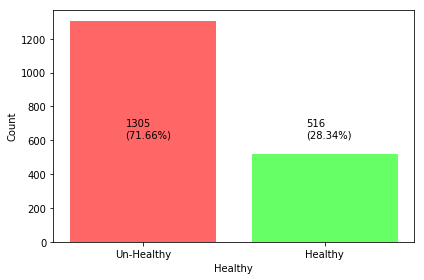

In [17]:
# Letus find the number of healthy and non-healthy leafs from data
plot_data_distribution('healthy', labels=['Un-Healthy', 'Healthy'], colours=['#FF6666','#66FF66'], xlabel='Healthy', ylabel='Count')

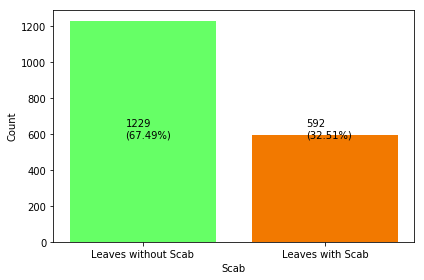

In [18]:
# Letus find the number of Scab leaves and non-scab leaves from data
plot_data_distribution('scab', labels=['Leaves without Scab', 'Leaves with Scab'], colours=['#66FF66', '#F27900'], xlabel='Scab', ylabel='Count')

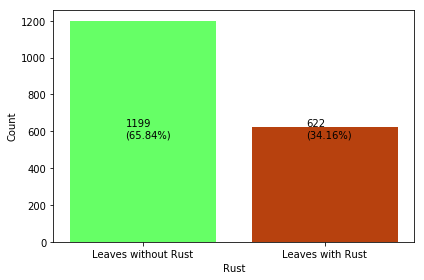

In [19]:
# Letus find the number of Rust leaves and non-rust leaves from data

plot_data_distribution('rust', labels=['Leaves without Rust', 'Leaves with Rust'], colours=['#66FF66', '#b7410e'], xlabel='Rust', ylabel='Count')

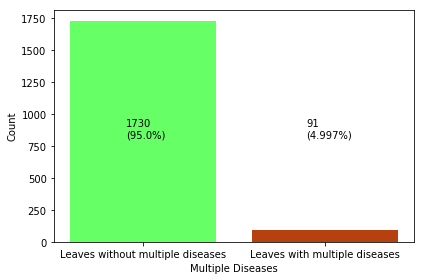

In [20]:
# Letus find the number of Multiple diseased leaves and leaves without multiple diseases from data

plot_data_distribution('multiple_diseases', labels=['Leaves without multiple diseases', 'Leaves with multiple diseases'], colours=['#66FF66', '#b7410e'], xlabel='Multiple Diseases', ylabel='Count')

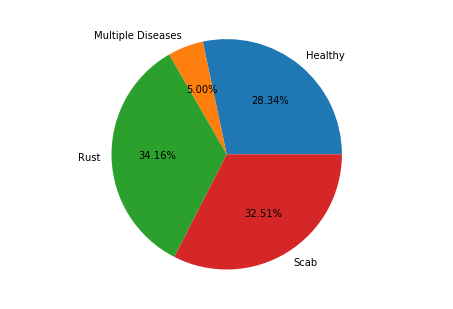

In [21]:
# Distribution of diseases 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
leaves = ['Healthy', 'Multiple Diseases', 'Rust', 'Scab']
healthy = len(train[train['healthy'] == 1])
multiple = len(train[train['multiple_diseases'] == 1])
rust = len(train[train['rust'] == 1])
scab = len(train[train['scab'] == 1])
total_count = [healthy, multiple, rust, scab]
ax.pie(total_count, labels = leaves,autopct='%1.2f%%')
plt.show()

#### Sample images from the dataset

In [22]:
# Load images 
def load_image(image_id): 
    image = cv2.imread(images_path + image_id + ".jpg")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train["image_id"][:1000].apply(load_image)

In [23]:
# function for loading the images form the dataset
def get_sample_images(image_type, skip = 0, take = 100):
    
    disease_cond_list = []
    if image_type == 'healthy':
        disease_cond_list = [1, 0, 0 , 0]
    elif image_type == 'multiple_diseases':
        disease_cond_list = [0, 1, 0, 0]
    elif image_type == 'rust':
        disease_cond_list = [0, 0, 1, 0]
    elif image_type == 'scab':
        disease_cond_list = [0, 0, 0, 1]
    else:
        disease_cond_list = [1, 0, 0, 0]

    if (len(disease_cond_list) > 1 ):
        data = train[(train['healthy'] == disease_cond_list[0]) & (train['scab'] == disease_cond_list[1]) & (train['rust'] == disease_cond_list[2]) & (train['multiple_diseases'] == disease_cond_list[3])][skip:][:take]
        
        images = train_images.loc[list(data.index)]
        cols, rows = 3, min([3, len(images)//3])

        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
        for col in range(cols):
            for row in range(rows):
                ax[row, col].imshow(images.loc[images.index[row*3+col]])
        plt.show()
    else:
        return None

#### Sample images of Healthy Leaves

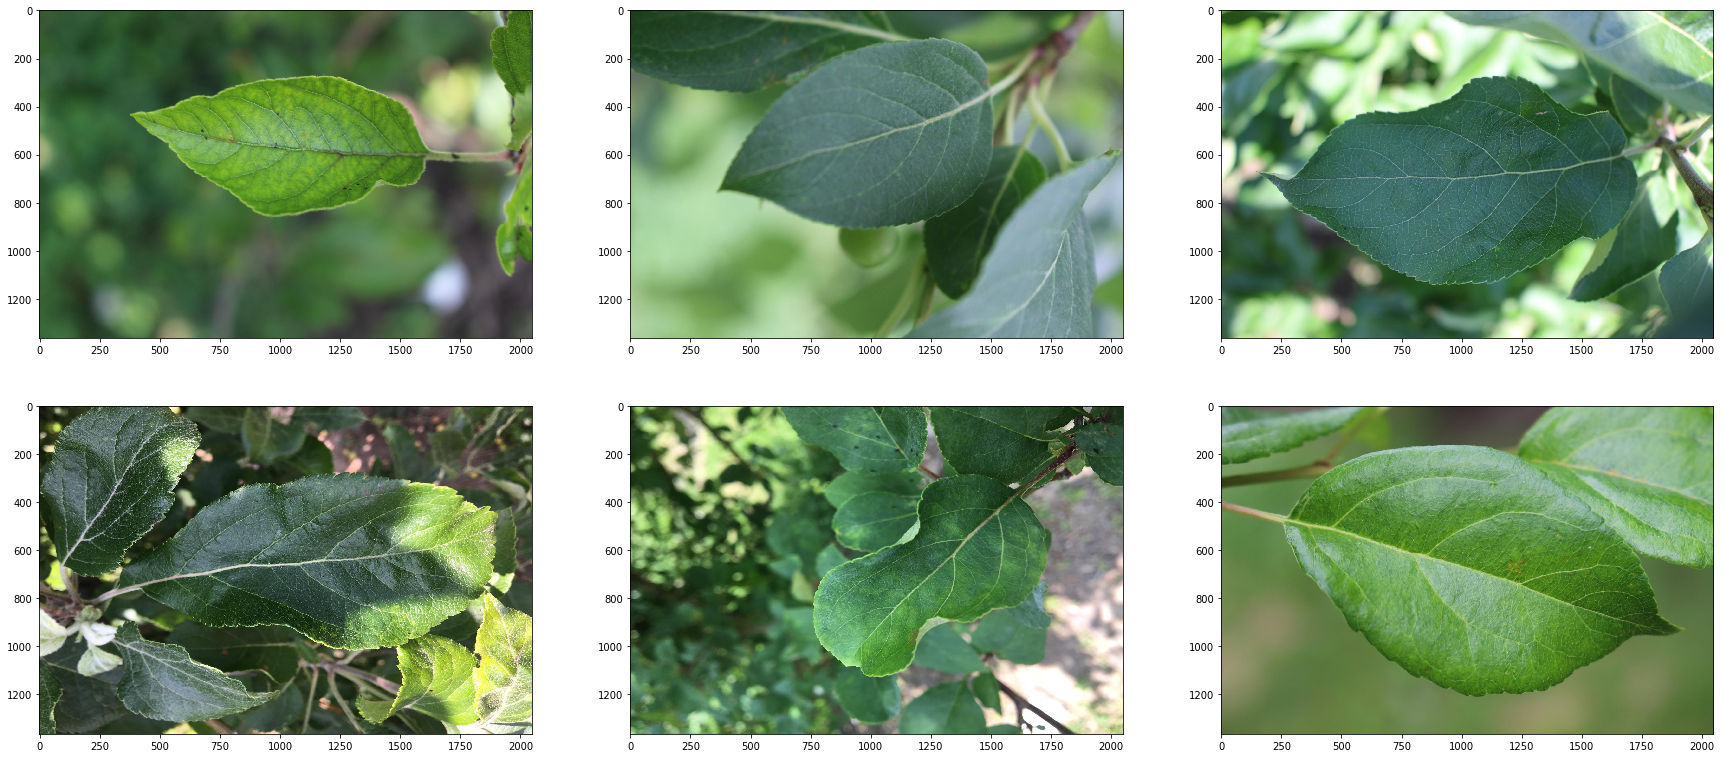

In [24]:
get_sample_images("healthy", 3, 6)

#### Sample images of leaves with multiple diseases

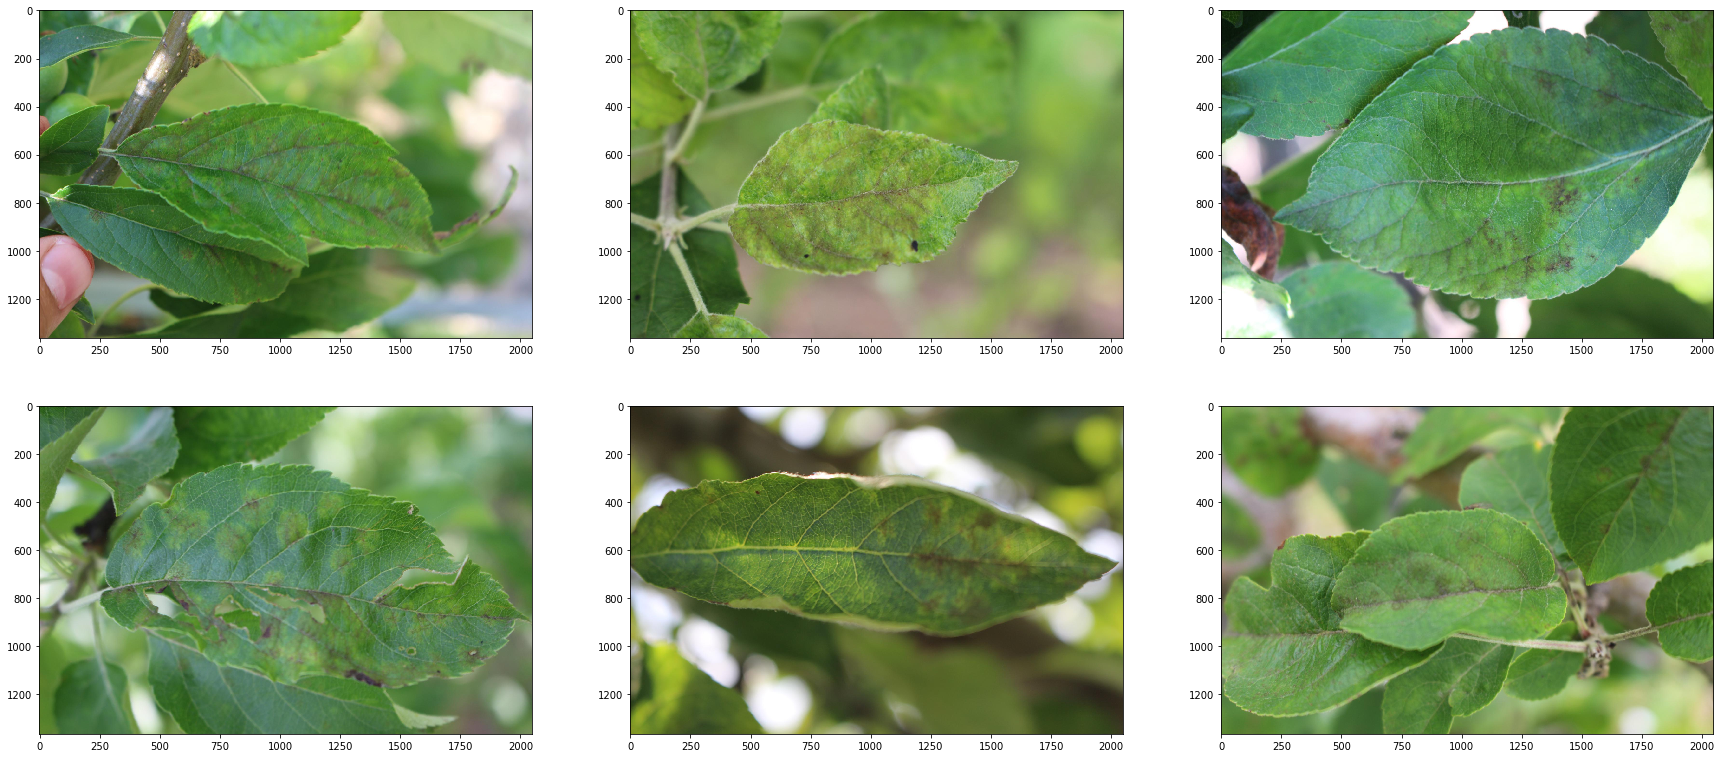

In [32]:
get_sample_images("multiple_diseases", 3, 6)

#### Sample images of leaves with rust

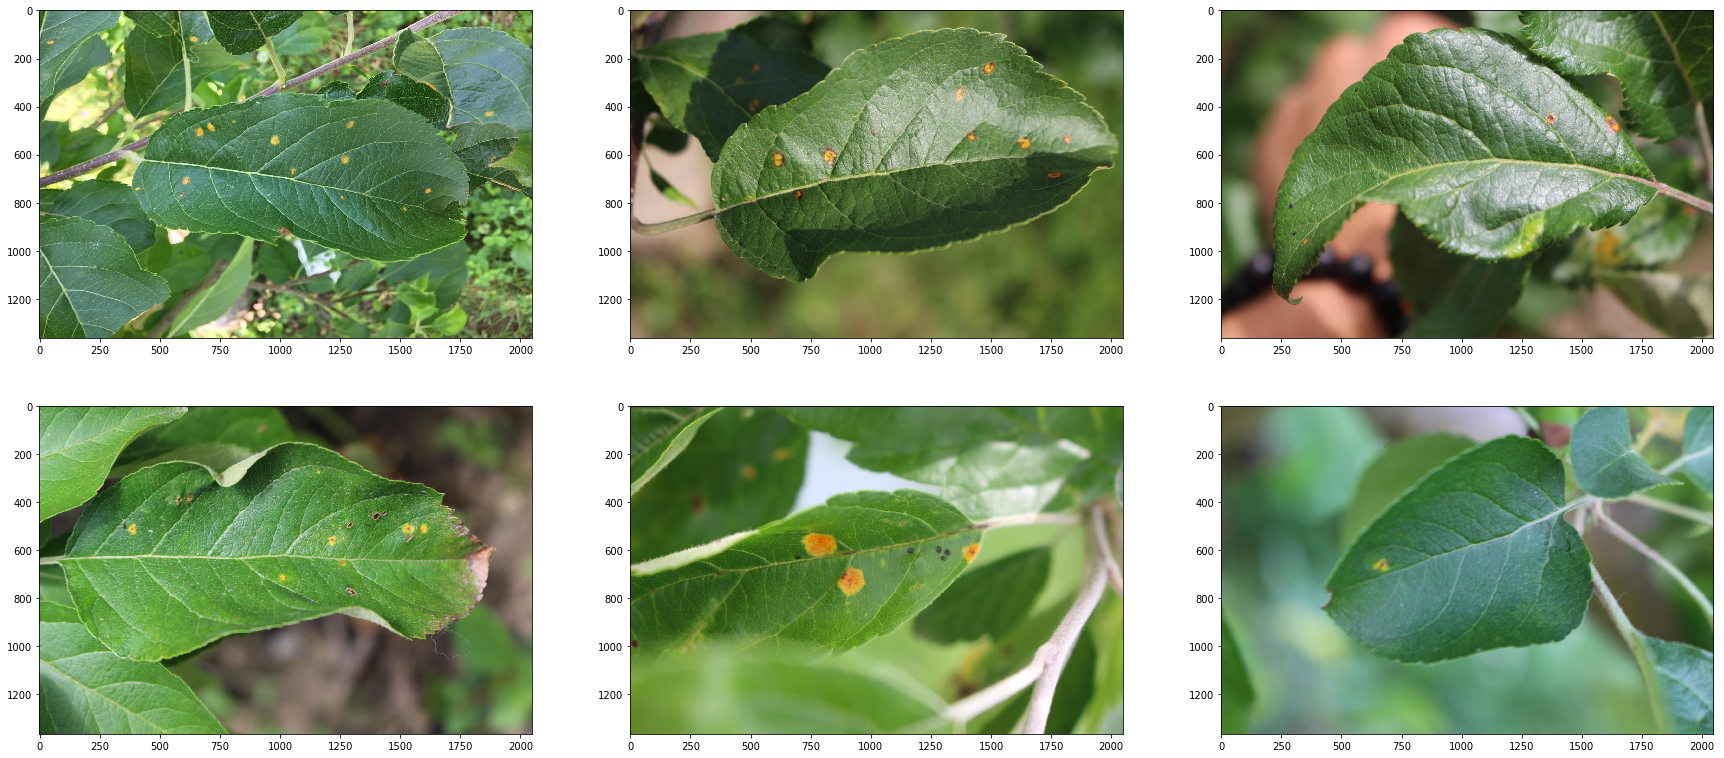

In [34]:
get_sample_images("rust", 3, 6)

#### Sample images of leaves with scab

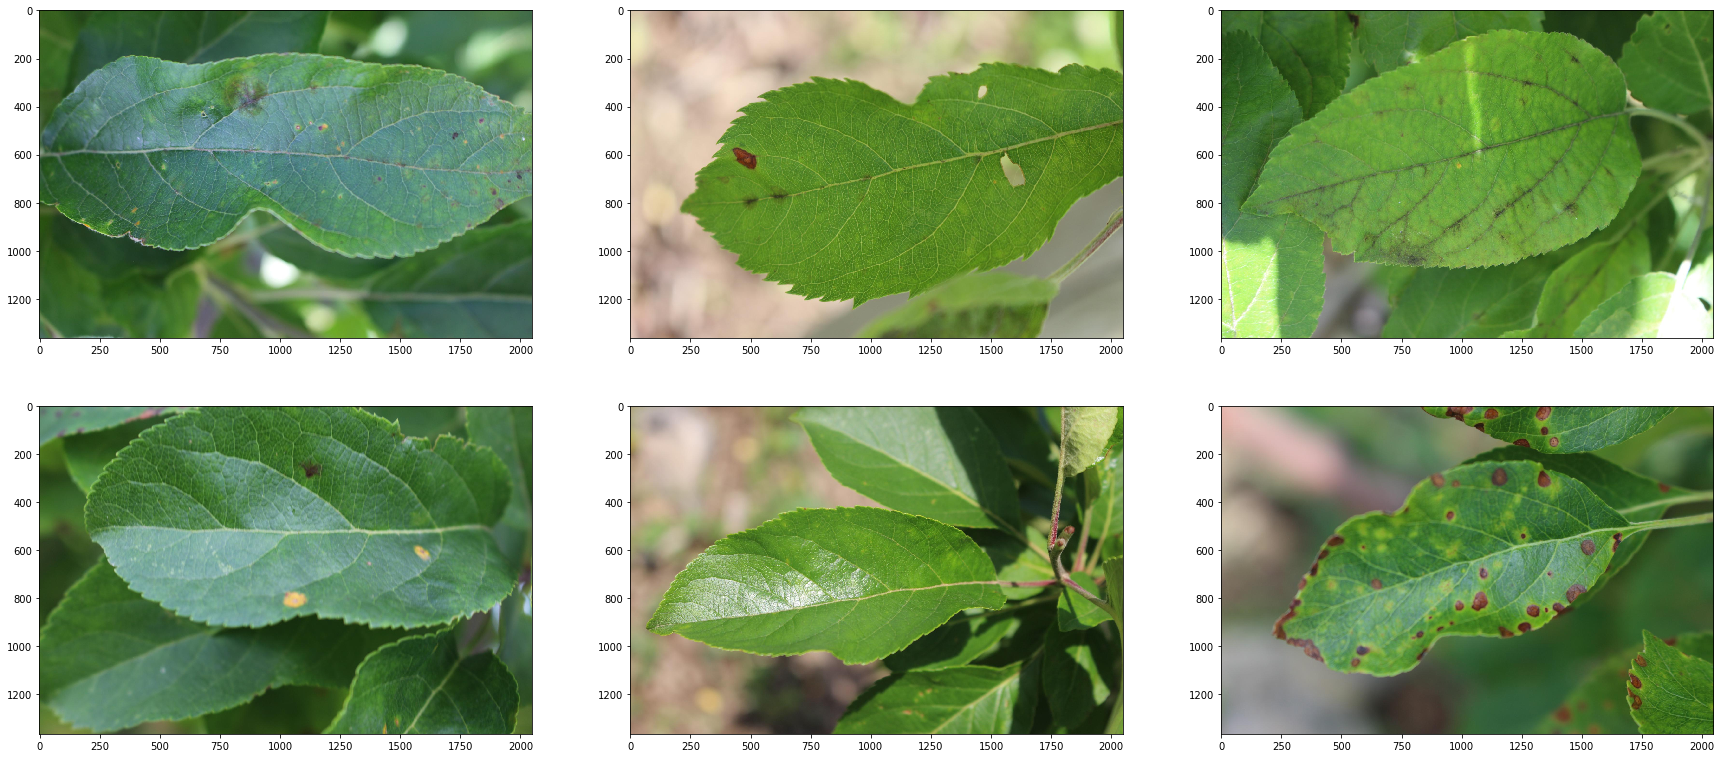

In [40]:
get_sample_images("scab", 3, 6)

#### Setup TPU Config

In [33]:
# AUTO = tf.data.experimental.AUTOTUNE
# # Detect hardware, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [30]:
def map_image_with_path(image):
    return images_path + image + '.jpg'

test_paths = test.image_id.apply(map_image_with_path).values
train_paths = train.image_id.apply(map_image_with_path).values

train_labels = train[['healthy', 'multiple_diseases', 'rust', 'scab']].values
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, test_size=0.15, random_state=45)

In [35]:
BATCH_SIZE= 32
img_size = 512
EPOCHS = 10
nb_classes = 6
PARALLEL_CALLS = -1

Learning rate schedule: 1e-05 to 0.0001 to 3.95e-05


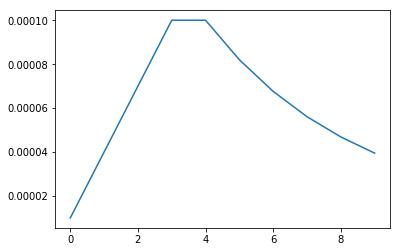

In [26]:
LR_START = 0.00001
LR_MAX = 0.0001
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 1
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [27]:
def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label

In [28]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [36]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=PARALLEL_CALLS)
    .map(data_augment, num_parallel_calls=PARALLEL_CALLS)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(PARALLEL_CALLS)
)

In [37]:
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=PARALLEL_CALLS)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(PARALLEL_CALLS)
)

In [39]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=PARALLEL_CALLS)
    .batch(BATCH_SIZE)
)

In [70]:
def get_emodel():
    with strategy.scope():
        en =efn.EfficientNetB3(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)
        en.trainable = True

        model = tf.keras.Sequential([
            en,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(train_labels.shape[1], activation='softmax')
        ])
        opt = Adam(learning_rate=1e-3)
        model.compile(optimizer = opt,
            loss = 'categorical_crossentropy',
            metrics=['accuracy']
        )
        print(model.summary())
        return model
    
model = get_emodel()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Functional) (None, 16, 16, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 6148      
Total params: 10,789,676
Trainable params: 10,702,380
Non-trainable params: 87,296
_________________________________________________________________
None


In [ ]:
%%time
Checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Enet_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
       save_weights_only=True,mode='max')
train_history1 = model.fit(
            train_dataset, 
            validation_data = valid_dataset, 
            steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,            
            validation_steps=valid_labels.shape[0] // BATCH_SIZE,            
            callbacks=[lr_callback, Checkpoint],
            epochs=EPOCHS,
            verbose=2
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10


In [ ]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure()
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.plot(H.history["accuracy"], label="train_acc")
        plt.plot(H.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc="lower left")
        plt.show()

In [ ]:
plot_training(train_history1)